In [1]:
# Import packages
import warnings

# For data manipulation
import numpy as np
import pandas as pd
import scipy.stats as stats
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# For metrics and helpful functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest


# For saving models
import pickle

# Read the data:

In [2]:
df = pd.read_csv('/Users/ice50l/Downloads/csv2/Employee2.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [4]:
df.shape

(4653, 9)

In [5]:
df.isna().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## EDA (Exploratory Data Analysis)

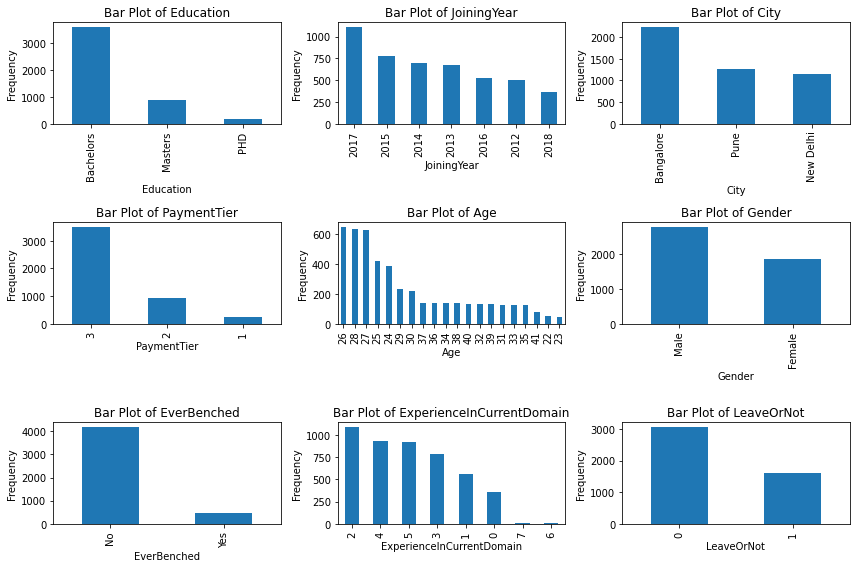

In [6]:
num_cols = 3
num_rows = len(df.columns) // num_cols + (len(df.columns) % num_cols > 0)

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate through columns and plot bar plots on subplots
for i, column in enumerate(df.columns):
    ax = axes[i // num_cols, i % num_cols]
    df[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Bar Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Remove empty subplots if the number of columns is not a multiple of 3
for i in range(len(df.columns), num_cols * num_rows):
    fig.delaxes(axes[i // num_cols, i % num_cols])

# Ensure proper layout and spacing
plt.tight_layout()
plt.show()

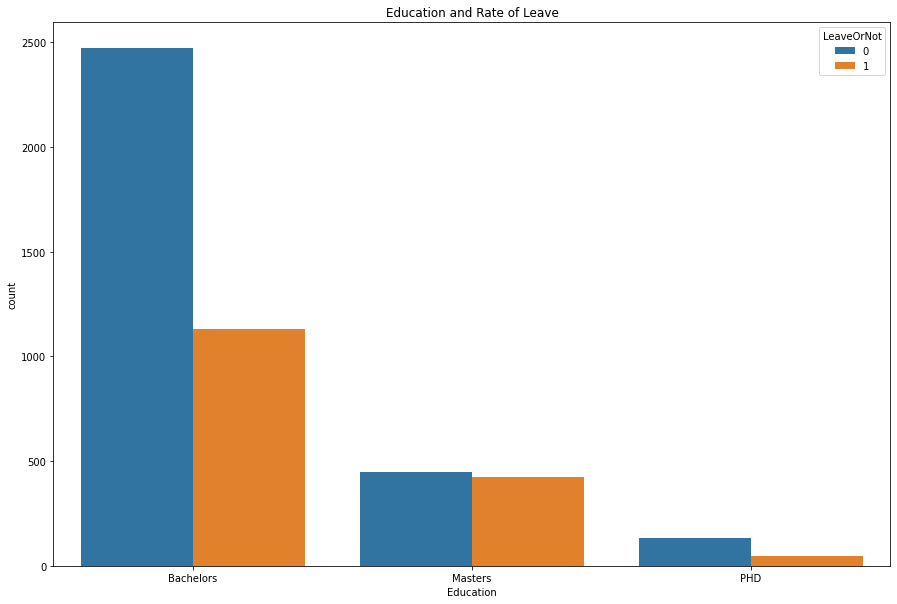

In [7]:
plt.figure(figsize = (15, 10))
sns.countplot(data = df, x = 'Education', hue = 'LeaveOrNot')
plt.title('Education and Rate of Leave')
plt.show()

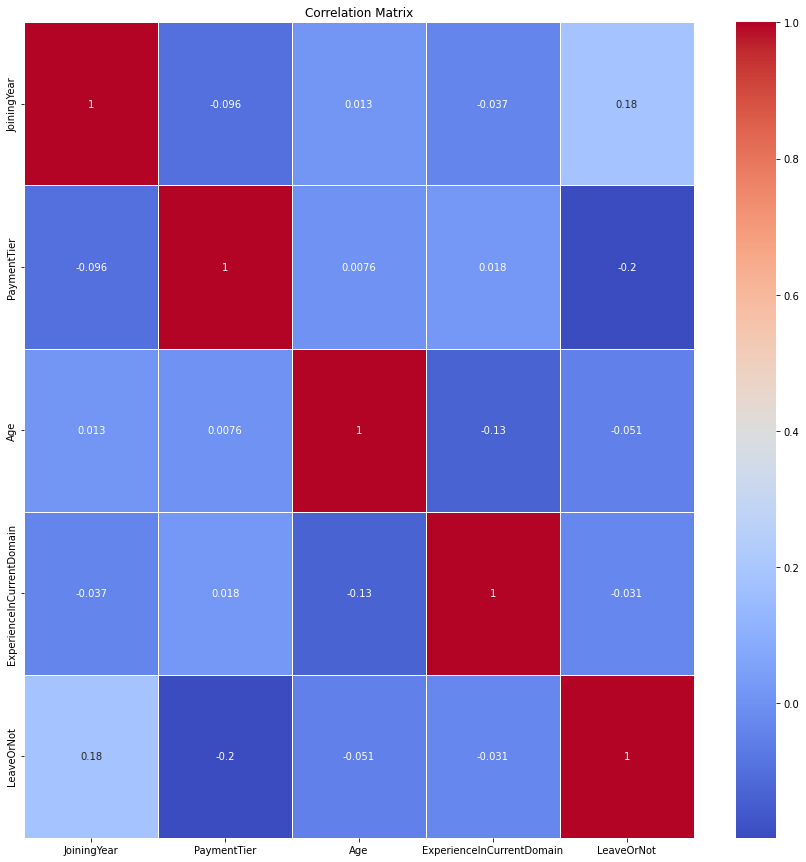

In [8]:
corr = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', linewidths = .5)
plt.title('Correlation Matrix')
plt.show()

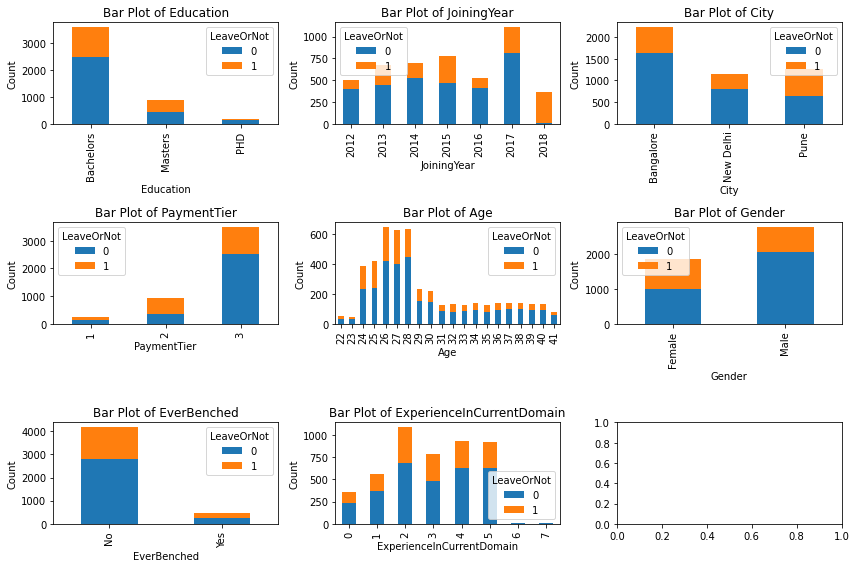

In [9]:
num_cols = 3
num_rows = len(df.columns) // num_cols + (len(df.columns) % num_cols > 0)

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate through columns and plot bar plots on subplots
for i, column in enumerate(df.columns):
    ax = axes[i // num_cols, i % num_cols]

    if column != 'LeaveOrNot':
        crosstab = pd.crosstab(df[column], df['LeaveOrNot'])
        crosstab.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'Bar Plot of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.legend(title='LeaveOrNot')

# Remove empty subplots if the number of columns is not a multiple of 3
if len(df.columns) % num_cols > 0:
    for i in range(len(df.columns), num_cols * num_rows):
        fig.delaxes(axes[i // num_cols, i % num_cols])

# Ensure proper layout and spacing
plt.tight_layout()
plt.show()

# Defining useful functions

In [10]:
from sklearn.metrics import roc_curve

def plot_roc_curve(model, y_test, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

    plt.figure(figsize = (15,10))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model + ' ROC Curve')
    plt.show()


In [11]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1, num_trainings))
    print(np.linspace(.1,1, num_trainings))
    print(train_sizes)
    print(train_scores)
    print(test_scores)

    train_scores_mean = np.mean(train_scores, axis = 1)
    print(train_scores_mean)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize = (15,10))
    plt.grid()
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = .1, color = 'g')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = .1, color = 'r')

    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'g', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'y', label = 'Cross-validation score')
    plt.legend(loc = 'best')
    plt.show()
    

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, y_test, y_pred):

    plt.figure(figsize = (15,10))
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt = 'g')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(model + ' Confusion Matrix')

# ML and Preprocessing

In [13]:
df = pd.get_dummies(df, columns=['Education', 'JoiningYear', 'City',
                                 'PaymentTier', 'Gender', 'EverBenched'])
df.shape

(4653, 23)

In [14]:
X = df.drop('LeaveOrNot', axis = 1)
y = df['LeaveOrNot']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [16]:
# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Logistic Regression:

In [17]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
logreg = LogisticRegression(random_state = 42, max_iter = 200)
param_dist = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
    'C': stats.uniform(0.01, 10)  # Narrower C range
}
lgrRandom = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=100, cv=3, random_state=42)
lgrRandom.fit(X, y)

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=200, random_state=42),
                   n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff3049e4b80>,
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga', 'liblinear']},
                   random_state=42)

In [18]:
lgrRandom.best_score_

0.7958306468944767

In [19]:
lgrRandom.best_params_

{'C': 1.844347898661638, 'solver': 'liblinear'}

In [20]:
logreg = LogisticRegression(C = 1.844347898661638, solver ='liblinear', random_state = 42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_pred, y_test)
print(f'The Score for Logistic Regression is: {logreg_acc}')

The Score for Logistic Regression is: 0.8184747583243824


In [21]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       701
           1       0.60      0.83      0.69       230

    accuracy                           0.82       931
   macro avg       0.77      0.82      0.78       931
weighted avg       0.85      0.82      0.83       931



Text(0.5, 0, 'Importance Score')

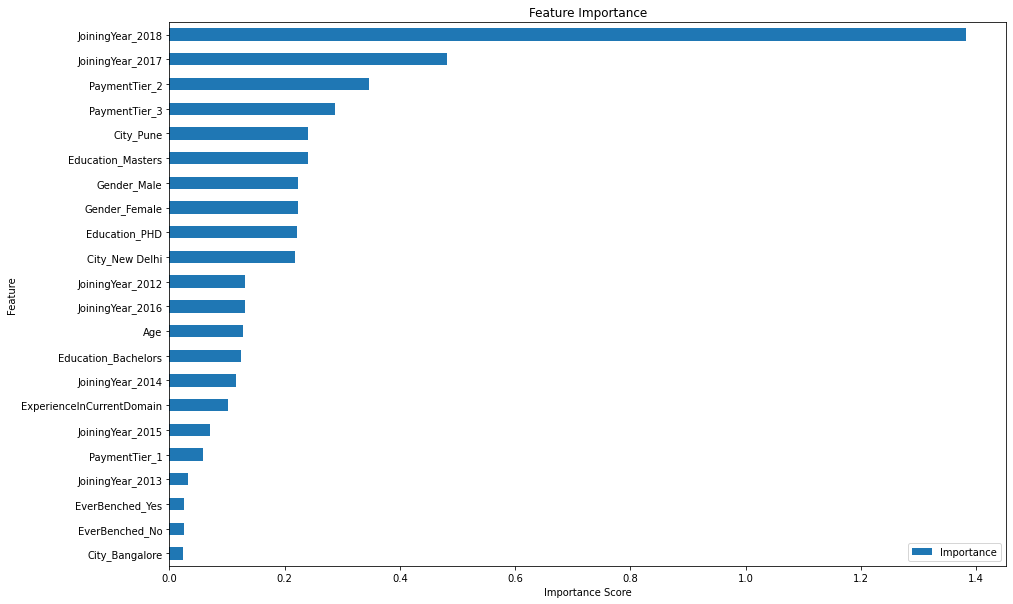

In [22]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(15, 10))
plt.title('Feature Importance')
plt.xlabel('Importance Score')

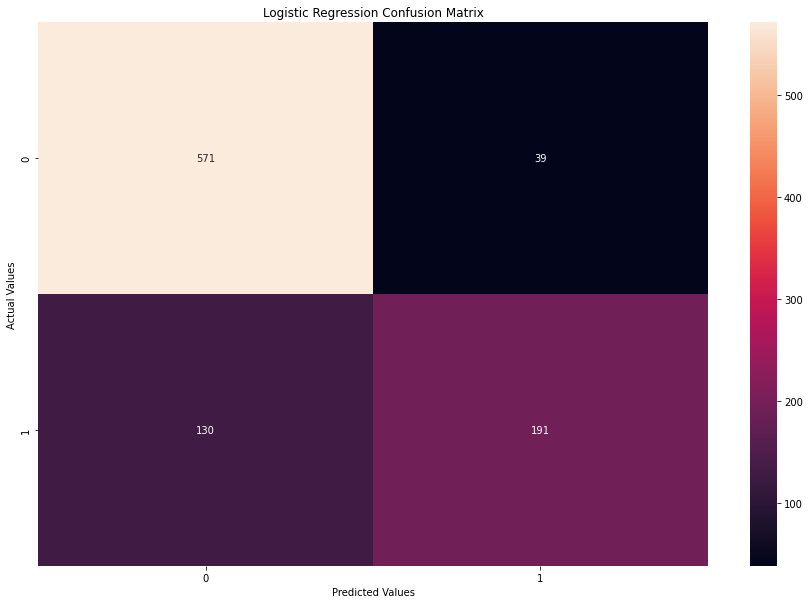

In [23]:
plot_confusion_matrix('Logistic Regression', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 372 1209 2047 2884 3722]
[[0.83064516 0.80107527 0.80107527 0.80107527 0.80107527]
 [0.79404467 0.77088503 0.79073615 0.79073615 0.79073615]
 [0.80801172 0.79384465 0.79042501 0.79042501 0.79042501]
 [0.81206657 0.8037448  0.80097087 0.79507628 0.79785021]
 [0.81219774 0.80682429 0.80521225 0.80252552 0.80306287]]
[[0.78839957 0.80021482 0.78732546 0.79247312 0.78387097]
 [0.79699248 0.7980666  0.78732546 0.79784946 0.79569892]
 [0.7980666  0.79484425 0.80021482 0.79892473 0.79462366]
 [0.79914071 0.79162191 0.80558539 0.81935484 0.79677419]
 [0.79699248 0.7905478  0.80773362 0.81075269 0.80537634]]
[0.80698925 0.78742763 0.79462628 0.80194175 0.80596454]


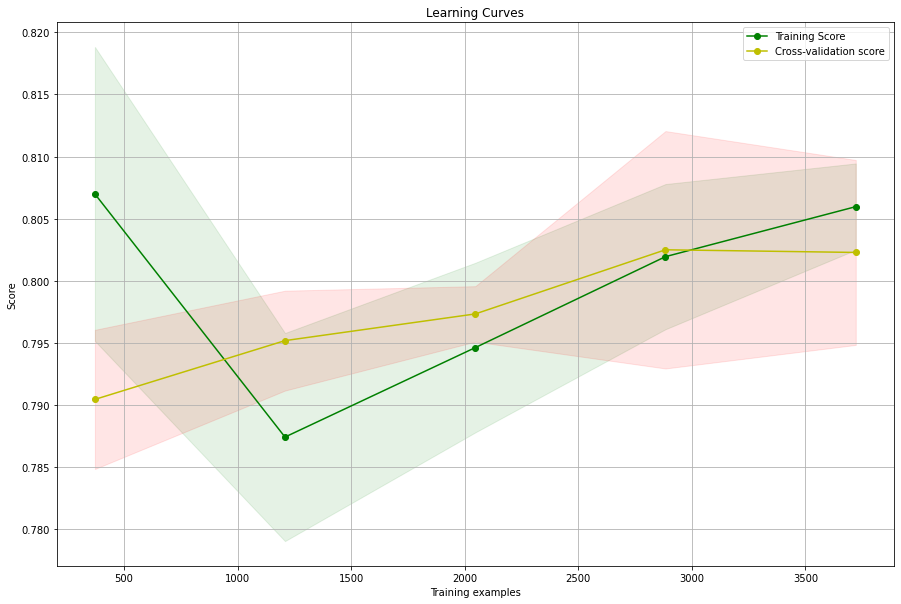

In [24]:
plot_learning_curve(X, y, logreg, 5)

In [25]:
y_pred_probs = logreg.predict_proba(X)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y, y_pred_probs))

The Probability is: 0.0021479036655297247
The AUC Score is: 0.7588865460203079


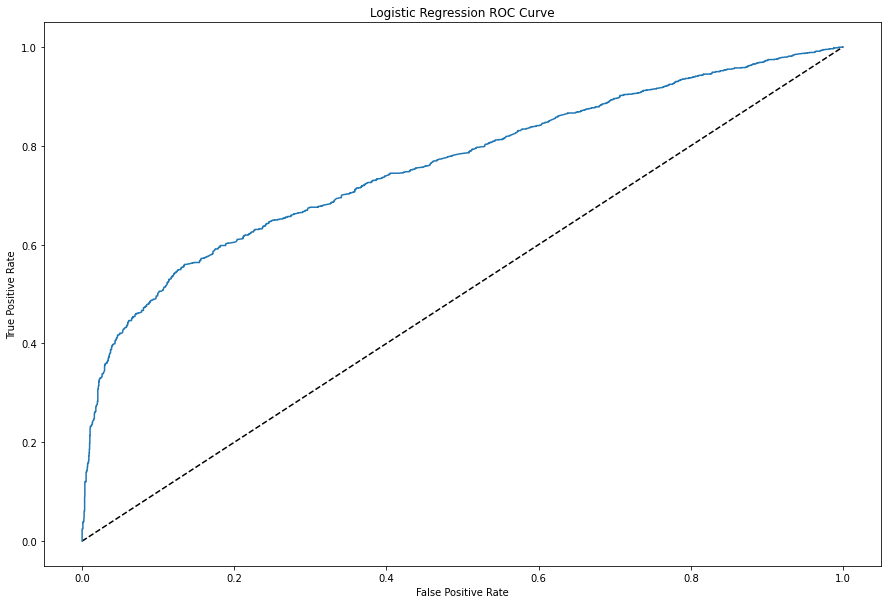

In [26]:
plot_roc_curve('Logistic Regression', y, y_pred_probs)

In [27]:
path = '/Users/ice50l/Downloads/models3/'

In [28]:
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [29]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

## Random Forest Classifier

In [30]:
'''''
rf = RandomForestClassifier(random_state = 42)
# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
gridrfc2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')
gridrfc2.fit(X_train, y_train)
'''''


"''\nrf = RandomForestClassifier(random_state = 42)\n# Assign a dictionary of hyperparameters to search over\ncv_params = {'max_depth': [3,5, None], \n             'max_features': [1.0],\n             'max_samples': [0.7, 1.0],\n             'min_samples_leaf': [1,2,3],\n             'min_samples_split': [2,3,4],\n             'n_estimators': [300, 500],\n             }  \n\n# Assign a dictionary of scoring metrics to capture\nscoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}\n\n# Instantiate GridSearch\ngridrfc2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')\ngridrfc2.fit(X_train, y_train)\n"

In [31]:
#write_pickle(path, gridrfc2, 'gridrfc2')

In [32]:
gridrfc2 = read_pickle(path, 'gridrfc2')

In [33]:
gridrfc2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [34]:
gridrfc2.best_score_

0.8615013078704803

In [35]:
gridrfc2.best_estimator_

RandomForestClassifier(max_depth=5, max_features=1.0, max_samples=0.7,
                       n_estimators=300, random_state=42)

In [36]:
rfc = RandomForestClassifier(max_depth=5, max_features=1.0, max_samples=0.7,
                       n_estimators=300, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc_acc = accuracy_score(y_pred, y_test)
print(f'The Accuracy Score for Random Forest Classifier is: {rfc_acc}')

The Accuracy Score for Random Forest Classifier is: 0.8754027926960258


In [37]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       686
           1       0.70      0.92      0.80       245

    accuracy                           0.88       931
   macro avg       0.83      0.89      0.85       931
weighted avg       0.90      0.88      0.88       931



Text(0, 0.5, 'Features')

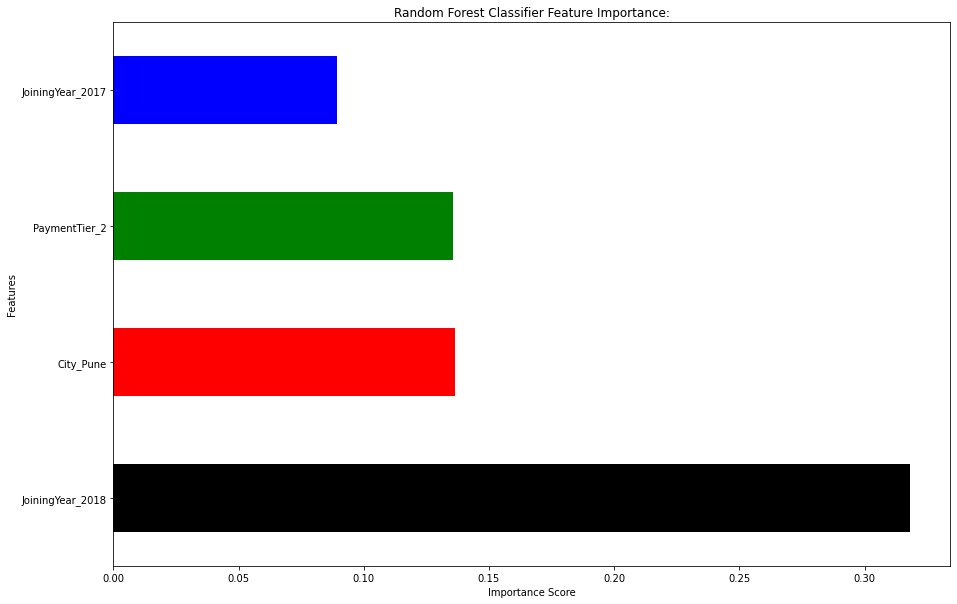

In [38]:
plt.figure(figsize = (15,10))
pd.Series(rfc.feature_importances_, index=X.columns).nlargest(4).plot(kind='barh', color = ['black', 'red', 'green', 'blue'])
plt.title('Random Forest Classifier Feature Importance:')
plt.xlabel('Importance Score')
plt.ylabel('Features')

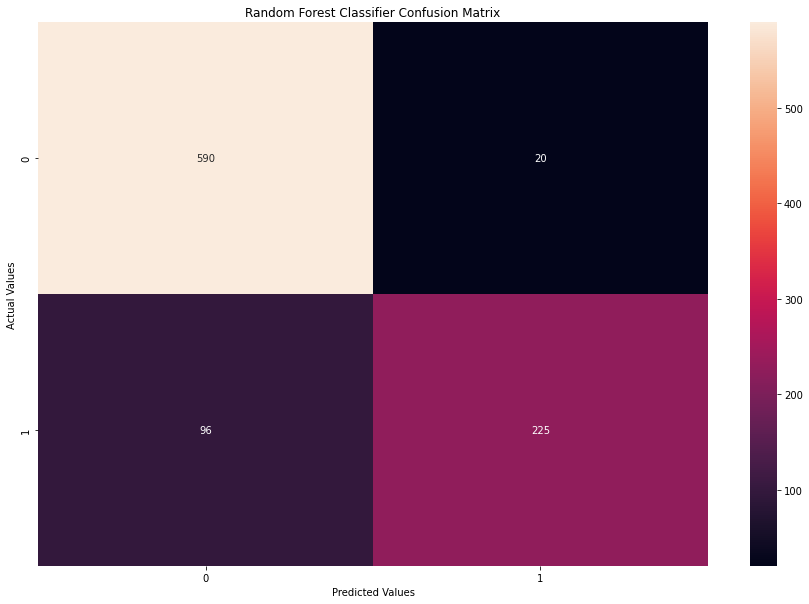

In [39]:
plot_confusion_matrix('Random Forest Classifier', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 372 1209 2047 2884 3722]
[[0.89516129 0.88172043 0.88172043 0.88172043 0.88172043]
 [0.85690653 0.84449959 0.85194376 0.85194376 0.85194376]
 [0.85979482 0.85490962 0.8641915  0.85148999 0.85148999]
 [0.85679612 0.85679612 0.8592233  0.8574896  0.85818308]
 [0.85706609 0.85867813 0.85626008 0.85384202 0.85411069]]
[[0.8216971  0.80128894 0.80665951 0.81505376 0.82258065]
 [0.82062299 0.83995704 0.83995704 0.84301075 0.85053763]
 [0.82277121 0.85499463 0.86573577 0.85376344 0.8516129 ]
 [0.82814178 0.84425349 0.86358754 0.86344086 0.8516129 ]
 [0.82384533 0.8453276  0.85929108 0.85698925 0.84731183]]
[0.8844086  0.85144748 0.85637518 0.85769764 0.8559914 ]


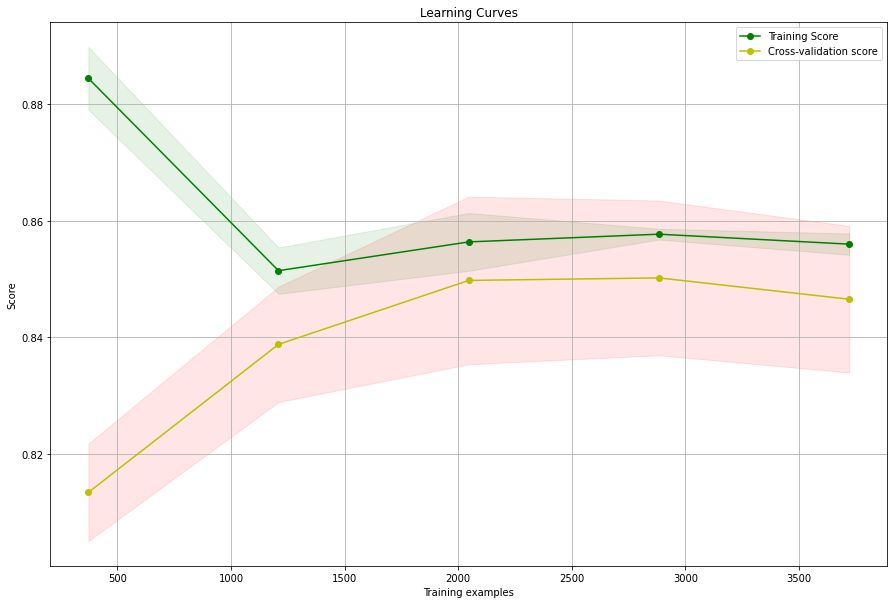

In [40]:
plot_learning_curve(X,y, rfc, 5)

In [41]:
y_pred_probs = rfc.predict_proba(X)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y, y_pred_probs))

The Probability is: 0.1545793548783255
The AUC Score is: 0.7609774197510645


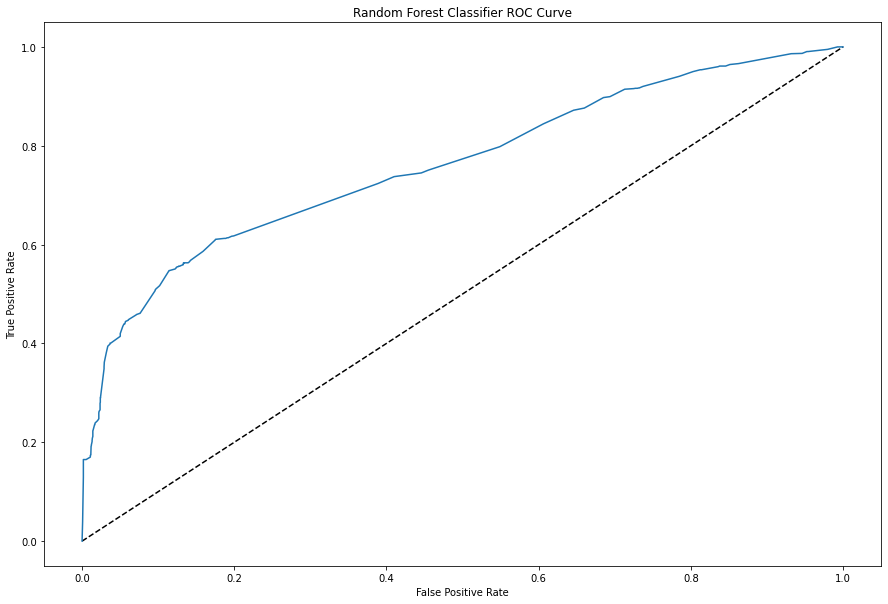

In [42]:
plot_roc_curve('Random Forest Classifier', y, y_pred_probs)

Feature importance for the random forest classifier.

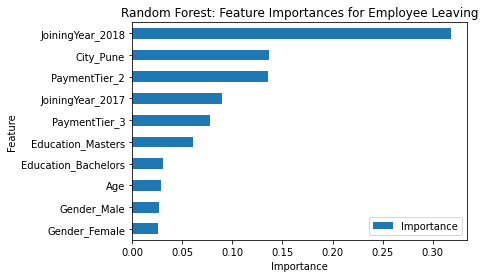

In [43]:
# Get feature importances
feat_impt = gridrfc2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(gridrfc2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

## XGBOOST

In [44]:
xgb = XGBClassifier(random_state = 42)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}
randxgb = RandomizedSearchCV(xgb, param_distributions = param_dist, cv = 5, scoring = 'accuracy')
randxgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff3049dc1c0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff304a023a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff304d8da00>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff304d9e1c0>},
                   scoring='accuracy')

In [45]:
randxgb.best_params_

{'learning_rate': 0.01271040953827536,
 'max_depth': 9,
 'n_estimators': 68,
 'subsample': 0.597195010025439}

In [46]:
randxgb.best_score_

0.8498112867142961

In [47]:
xgb = XGBClassifier(learning_rate = 0.06530185896587935, max_depth = 7, n_estimators = 102, subsample = 0.985418790323892)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_pred, y_test)
print(f'The accuracy Score for XGBOOST is: {xgb_acc}')

The accuracy Score for XGBOOST is: 0.874328678839957


In [48]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       673
           1       0.72      0.90      0.80       258

    accuracy                           0.87       931
   macro avg       0.84      0.88      0.85       931
weighted avg       0.89      0.87      0.88       931



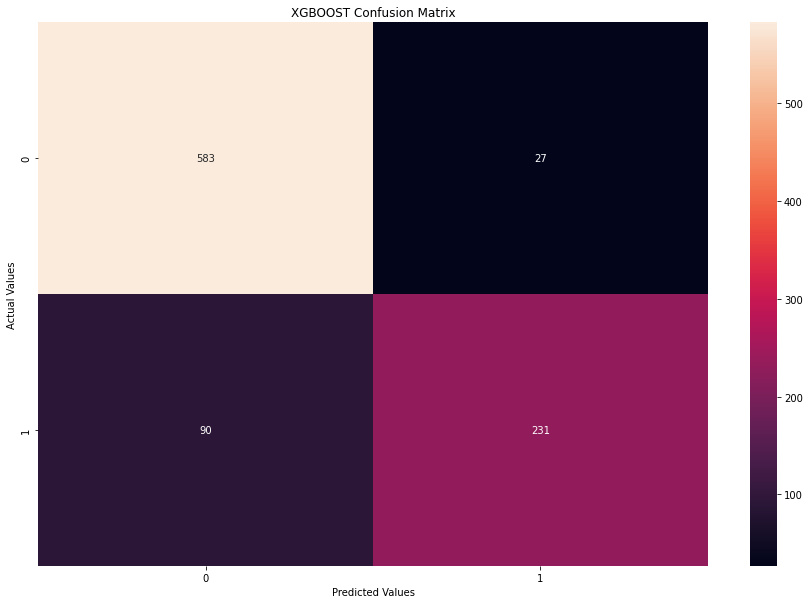

In [49]:
plot_confusion_matrix('XGBOOST', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 372 1209 2047 2884 3722]
[[0.93817204 0.91935484 0.91935484 0.91935484 0.91935484]
 [0.88668321 0.88254756 0.90074442 0.90074442 0.90074442]
 [0.89301417 0.88177821 0.88715193 0.88177821 0.88177821]
 [0.89112344 0.88418863 0.88349515 0.88418863 0.8831484 ]
 [0.88769479 0.88205266 0.88178399 0.88124664 0.88124664]]
[[0.81095596 0.82599356 0.81740064 0.81397849 0.81827957]
 [0.82814178 0.85069817 0.8603652  0.84623656 0.8483871 ]
 [0.83243824 0.84640172 0.86251343 0.8516129  0.85268817]
 [0.83888292 0.84640172 0.87003222 0.84086022 0.8483871 ]
 [0.84210526 0.85714286 0.86573577 0.84516129 0.85053763]]
[0.92311828 0.8942928  0.88510015 0.88522885 0.88280494]


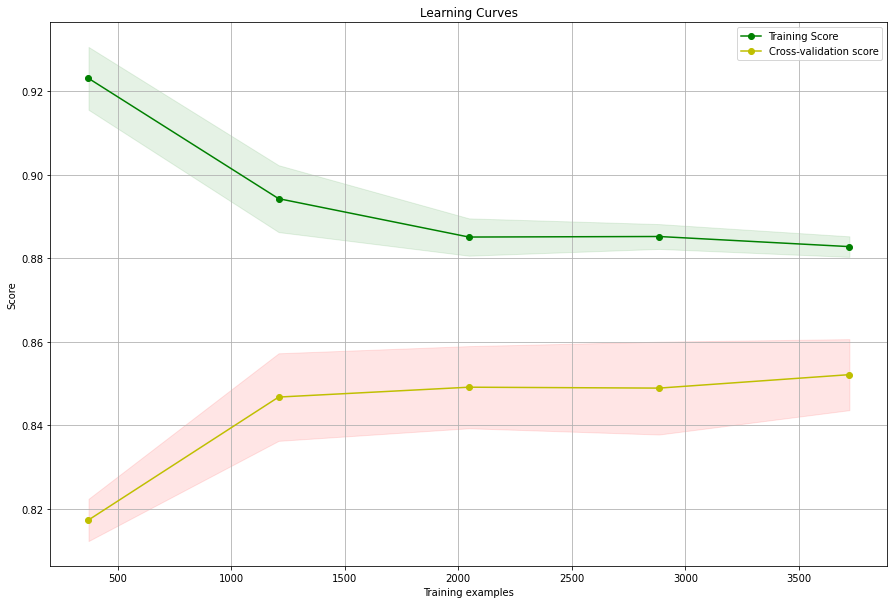

In [50]:
plot_learning_curve(X,y, xgb, 5)

In [51]:
y_pred_probs = xgb.predict_proba(X)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y, y_pred_probs))

The Probability is: 0.10041894018650055
The AUC Score is: 0.7282658450704224


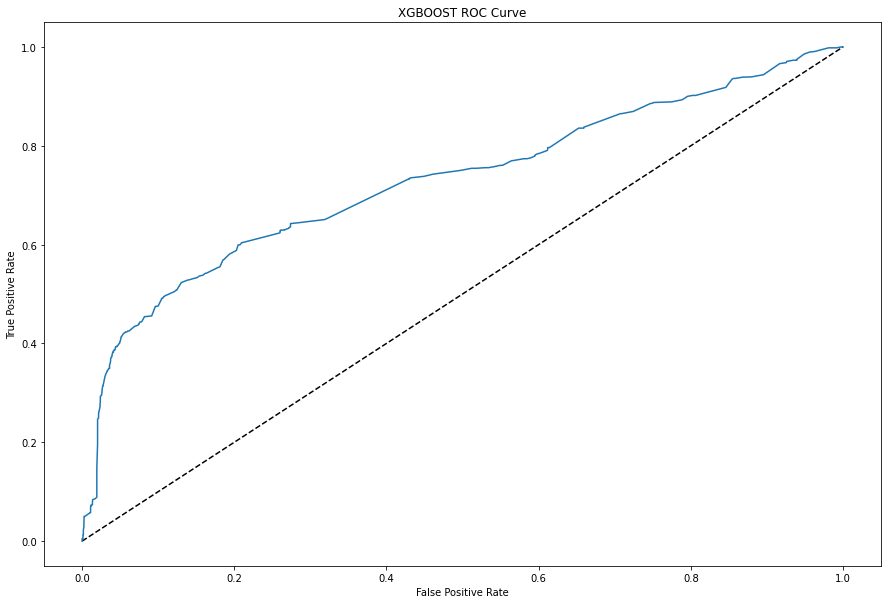

In [52]:
plot_roc_curve('XGBOOST', y, y_pred_probs)

## Support Vector Machine:

In [53]:
sv = SVC()

param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': [0.001, 0.01, 0.1]  # Kernel coefficient (for 'rbf' kernel)
}
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

gridsv = GridSearchCV(sv, param_grid, scoring=scoring, cv=4, refit='roc_auc')
gridsv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf']},
             refit='roc_auc',
             scoring={'f1', 'roc_auc', 'accuracy', 'precision', 'recall'})

In [54]:
gridsv.best_estimator_

SVC(C=10, gamma=0.01)

In [55]:
gridsv.best_score_

0.8425256889204349

In [56]:
sv = SVC(C=10, gamma=0.01)
sv.fit(X_test,y_test)
y_pred = sv.predict(X_test)
svc_acc = accuracy_score(y_pred, y_test)
print(f'The SVC Accuracy Score is: {svc_acc}')

The SVC Accuracy Score is: 0.882921589688507


In [57]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       683
           1       0.72      0.93      0.81       248

    accuracy                           0.88       931
   macro avg       0.84      0.90      0.86       931
weighted avg       0.90      0.88      0.89       931



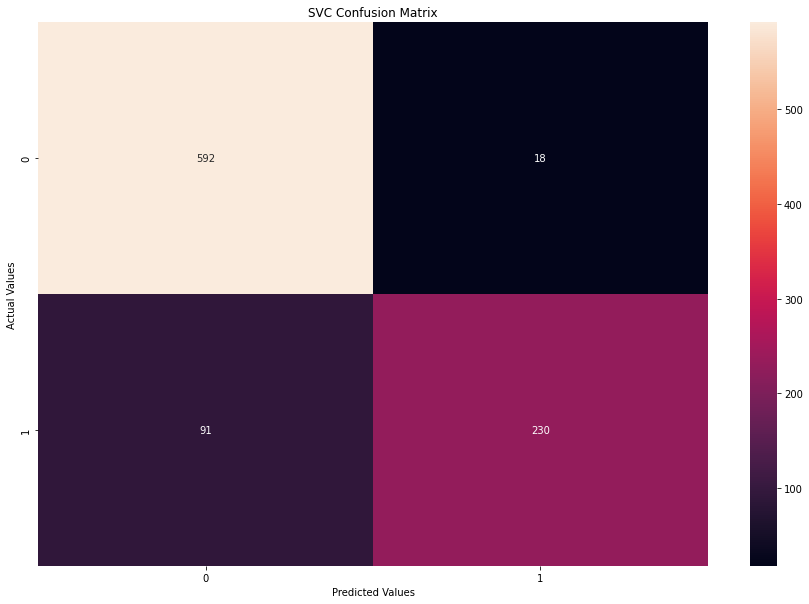

In [58]:
plot_confusion_matrix('SVC', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 372 1209 2047 2884 3722]
[[0.81451613 0.82795699 0.82795699 0.82795699 0.82795699]
 [0.79569892 0.81058726 0.82382134 0.82382134 0.82382134]
 [0.83732291 0.82608696 0.8221788  0.81338544 0.81338544]
 [0.83945908 0.82662968 0.82004161 0.83599168 0.83980583]
 [0.84040838 0.82885545 0.8323482  0.83960236 0.84013971]]
[[0.80021482 0.80343716 0.80558539 0.7483871  0.75591398]
 [0.80665951 0.7980666  0.8216971  0.77526882 0.78064516]
 [0.8216971  0.80558539 0.8216971  0.78817204 0.78817204]
 [0.81847476 0.80665951 0.82599356 0.82365591 0.79784946]
 [0.8216971  0.80451128 0.82599356 0.82688172 0.82580645]]
[0.82526882 0.81555004 0.82247191 0.83238558 0.83627082]


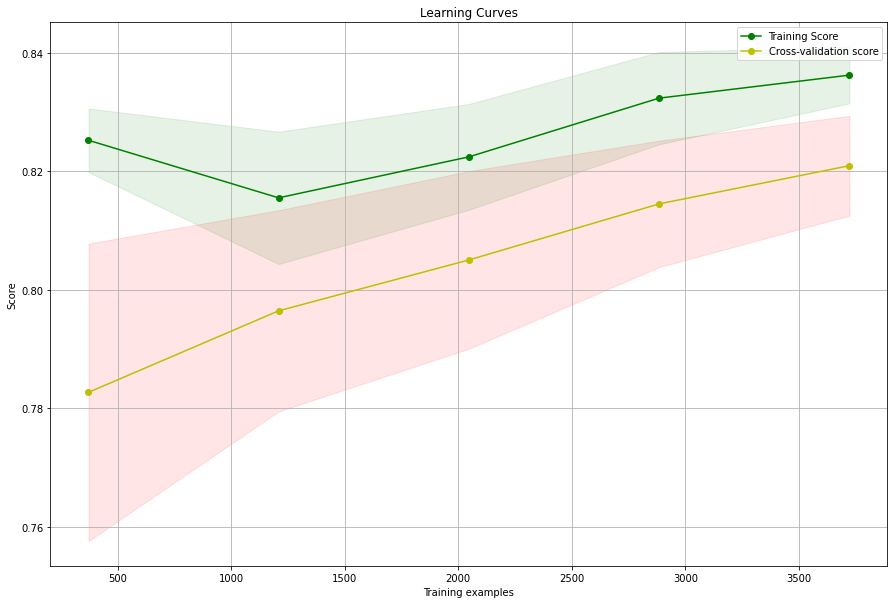

In [59]:
plot_learning_curve(X,y, sv, 5)

## Naive Bayes (Bernoulli)

In [60]:
bern = BernoulliNB()
param_grid = {
    'alpha': [0.1, 1.0, 10.0],  # Additive (Laplace/Lidstone) smoothing parameter
    'binarize': [0.0, 0.1, 0.2],  # Threshold for binarizing the input features
}

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

gridbern = GridSearchCV(bern, param_grid, scoring=scoring, cv=4, refit='roc_auc')
gridbern.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=BernoulliNB(),
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'binarize': [0.0, 0.1, 0.2]},
             refit='roc_auc',
             scoring={'f1', 'roc_auc', 'accuracy', 'precision', 'recall'})

In [61]:
gridbern.best_estimator_

BernoulliNB(alpha=0.1, binarize=0.2)

In [62]:
gridbern.best_score_

0.7916361432065471

In [63]:
bern = BernoulliNB(alpha=0.1, binarize=0.2)
bern.fit(X_train, y_train)
y_pred = bern.predict(X_test)
bern_acc = accuracy_score(y_pred, y_test)
print(f'The Naive Bayes Score is: {bern_acc}')

The Naive Bayes Score is: 0.8098818474758325


In [64]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       631
           1       0.69      0.74      0.71       300

    accuracy                           0.81       931
   macro avg       0.78      0.79      0.79       931
weighted avg       0.81      0.81      0.81       931



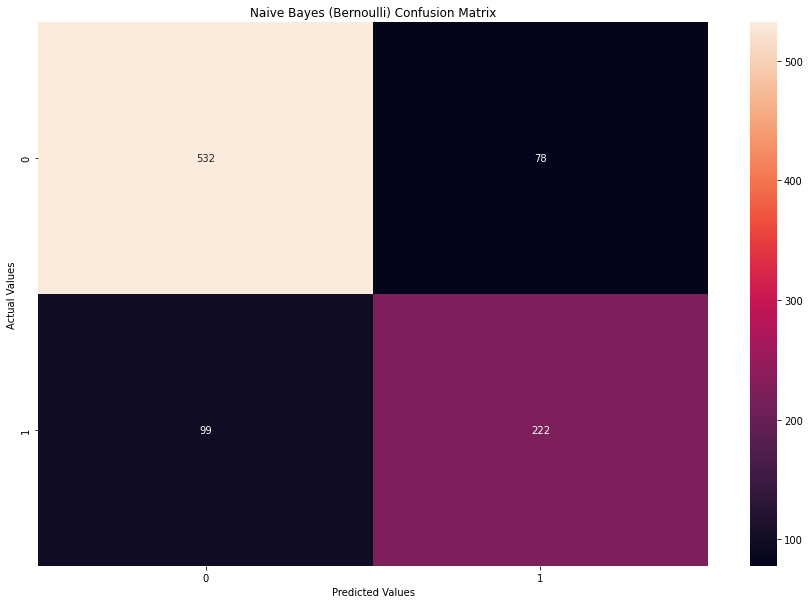

In [65]:
plot_confusion_matrix('Naive Bayes (Bernoulli)', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 372 1209 2047 2884 3722]
[[0.81451613 0.79301075 0.79301075 0.79301075 0.79301075]
 [0.79900744 0.76840364 0.78577337 0.78577337 0.78577337]
 [0.79286761 0.77918906 0.78407426 0.78309722 0.78309722]
 [0.80062413 0.78432732 0.79056865 0.78848821 0.78536755]
 [0.79554003 0.78667383 0.7909726  0.79070392 0.78882321]]
[[0.77013963 0.80665951 0.79162191 0.80107527 0.78817204]
 [0.77443609 0.79699248 0.77228786 0.77311828 0.7827957 ]
 [0.77980666 0.7980666  0.77658432 0.77956989 0.78817204]
 [0.78088077 0.79914071 0.78195489 0.78602151 0.79247312]
 [0.78195489 0.7980666  0.78195489 0.78602151 0.79462366]]
[0.79731183 0.78494624 0.78446507 0.78987517 0.79054272]


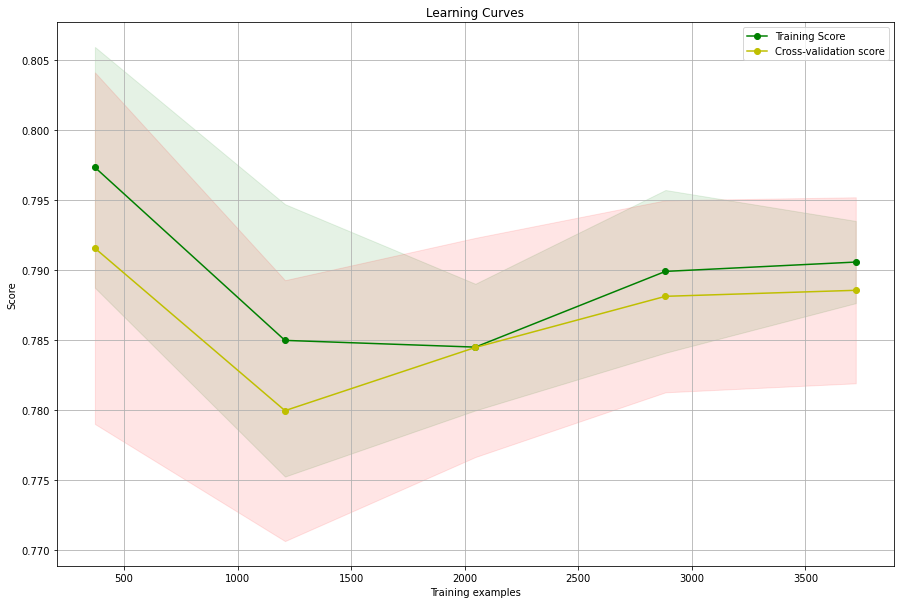

In [66]:
plot_learning_curve(X,y, bern, 5)

In [67]:
y_pred_probs = bern.predict_proba(X)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y, y_pred_probs))

The Probability is: 0.03333603836779507
The AUC Score is: 0.796943170651818


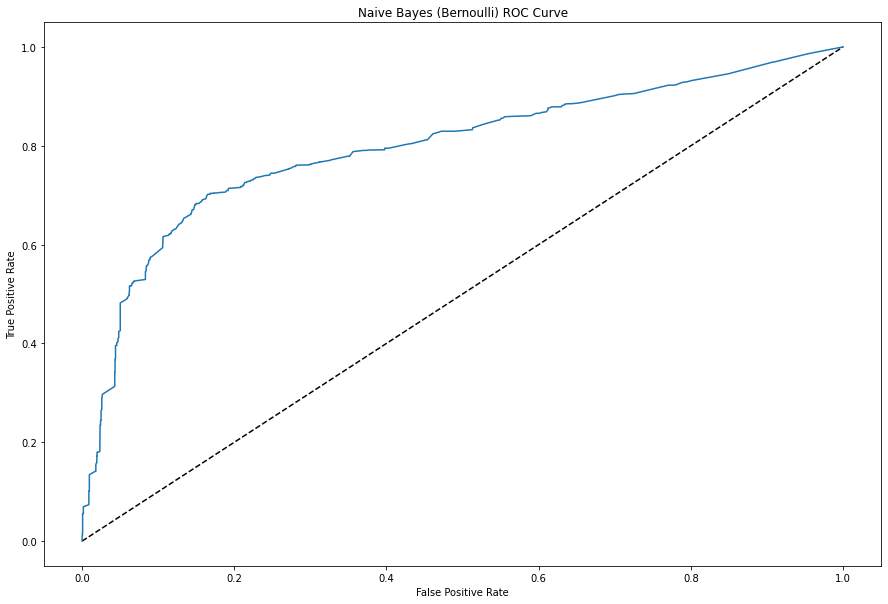

In [68]:
plot_roc_curve('Naive Bayes (Bernoulli)', y, y_pred_probs)

## Model Selection:

In [69]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier', 'XG Boost', 'SVC', 'Naive Bayes (Bernoulli)'],
    'Score': [logreg_acc, rfc_acc, xgb_acc, svc_acc, bern_acc]
 })
models = models.sort_values('Score', ascending = False)
models

,Model,Score
3,SVC,0.882922
1,Random Forest Classifier,0.875403
2,XG Boost,0.874329
0,Logistic Regression,0.818475
4,Naive Bayes (Bernoulli),0.809882


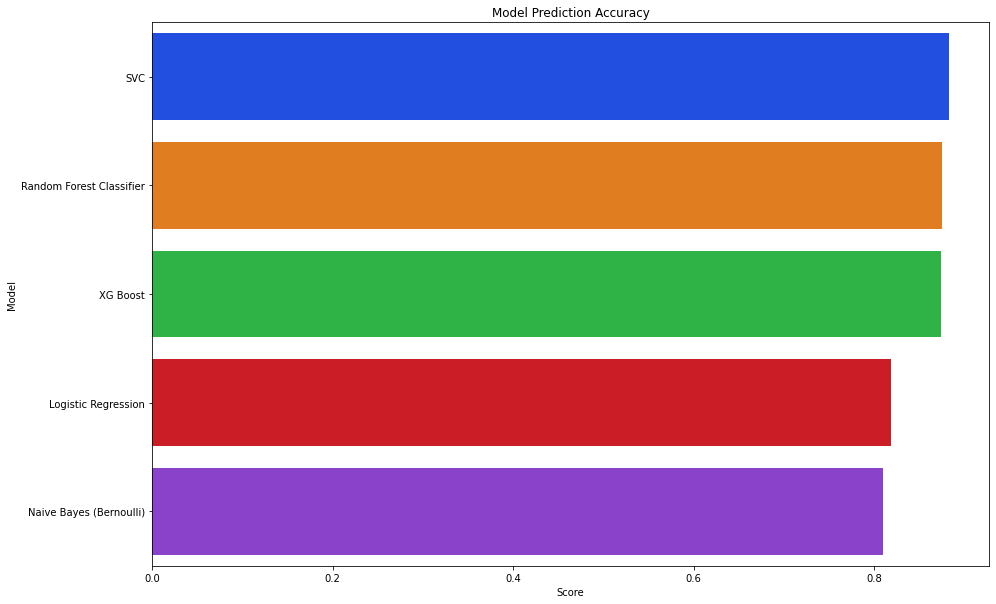

In [70]:
plt.figure(figsize = (15,10))
sns.barplot(data = models, 
            y = 'Model', 
            x = 'Score',
            palette = 'bright')
plt.title('Model Prediction Accuracy')
plt.show()